# Representation of text data

Using the notebook from the previous homework we extracted around 45K reviews from 1000 movies. We will use this dataset to experiment with different methods of representation of text data.

In [16]:
import pandas as pd

df = pd.read_csv("../homework 1/imdb_reviews.csv", index_col=0)
df.head()

,movie,title,text,score,user,date,helpfulness_votes,positive_helpfulness_votes
0,Couples Retreat,Worst movie I've seen in a while...,I watched this for free On Demand and still fe...,5.0,glyeakley,2010/09/25,47,30
1,Disaster Movie,The irony is very correct.,"Since the name of the movie is ""Disaster Movie...",NaN,mewte,2008/08/29,411,345
2,Seven Psychopaths,"Skinny, toothless, and blind","Hmm, it's quite risky with all these movies th...",6.0,mircea-lungu,2013/04/21,24,11
3,The Counselor,"A dark, bleak masterpiece about predators - 10/10",Don't believe the bad reviews here: If you lov...,10.0,rockenrohl,2013/10/26,139,86
4,Scouts Guide to the Zombie Apocalypse,Scouts vs. Zombies gotta like that!,Comedy and Horror mix well in this coming of a...,6.0,philipmorrison-73118,2016/01/24,3,2


We will keep only the text and score fields since we are aiming at a classification task for positive, negative and neutral reviews. We also remove any reviews without a score. We will reduce the dataset size to 10K, just because we wanted to speed up some of the methods presented below, that otherwise would take a long time.

In [17]:
df = df.drop(["movie", "title", "user", "date", "helpfulness_votes", "positive_helpfulness_votes"], axis=1)
df = df.dropna()
df = df.sample(n=10000)
print(len(df))
df.head()

10000


,text,score
40974,There are three previous reviews about this fi...,3.0
36034,"Now, I knew going into this that it wasn't in ...",7.0
18373,I saw the movie last week. A real waste of tim...,1.0
4492,This could be an average to good slow burn hor...,3.0
2347,Just another lame excuse for make-up artist to...,1.0


We plot the frequencies for each possible score in the dataset.

<AxesSubplot:>

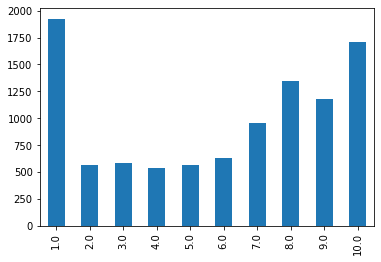

In [18]:
df["score"].value_counts().sort_index().plot(kind="bar")

As we can see the dataset is imbalanced, as we have more positive reviews. That is to be expected since we collected those reviews from somewhat popular movies.

For our classification purposes we will consider any score less than or equal to 3 to be negative, anything at least 8, positive, and the rest neutral.

In [19]:
def class_from_score(score):
    if score <= 3:
        return -1
    elif score >= 8:
        return 1
    else:
        return 0

df["class"] = [class_from_score(score) for score in df["score"]]
df.head()

,text,score,class
40974,There are three previous reviews about this fi...,3.0,-1
36034,"Now, I knew going into this that it wasn't in ...",7.0,0
18373,I saw the movie last week. A real waste of tim...,1.0,-1
4492,This could be an average to good slow burn hor...,3.0,-1
2347,Just another lame excuse for make-up artist to...,1.0,-1


<AxesSubplot:>

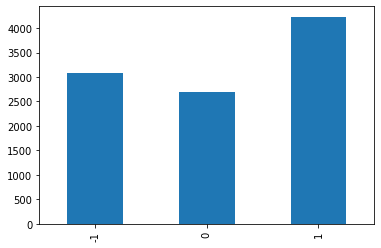

In [20]:
df["class"].value_counts().sort_index().plot(kind="bar")

We split our dataset into train (80%), dev (10%) and test (10%) sets.

In [21]:
from sklearn.model_selection import train_test_split

df = df.drop(["score"], axis=1)
df_train, df_rest = train_test_split(df, test_size=0.2)
df_dev, df_test = train_test_split(df_rest, test_size=0.5)

df_train.reset_index(inplace=True, drop=True)
df_dev.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

print(len(df_train), len(df_dev), len(df_test))
df_train.head()

8000 1000 1000


,text,class
0,"It's rare that a movie lives up to its hype, e...",1
1,I have always been a big fan of the Indy movie...,-1
2,Oh. My. God. It was so bad we were laughing at...,-1
3,"This film is Junk. The trailer is super cool ,...",-1
4,When producers and directors work with a big b...,-1


## CountVectorizer
The first example uses the CountVectorizer class from scikit-learn. With this we can build a bag-of-words representation of our text data.

First thing we need to take care of is the preprocessing and tokenization of our data. Recall that some cleaning of the data was done in the previous notebook. Here we will remove the URLs from the text (all URLs were previously replaced with a special token). We will then remove all symbols except latin letters, digits and basic punctuation. All spaces will then be contracted and stripped. We finish the preprocessing step with lower-casing our text.

For tokenization, we use SpaCy, after which each token is run through a stemmer, returning, in the end, the list of our tokens.

In [22]:
import nltk
import re
import spacy

stemmer = nltk.stem.PorterStemmer()
spacy_nlp = spacy.load("en_core_web_md")

def remove_url(text):
    return text.replace("[URL]", "")

def remove_symbols(text):
    return re.sub(r"[^a-zA-Z0-9.,?!'-]", " ", text)

def contract_spaces(text):
    return re.sub("\s+", " ", text).strip()

def lowercase(text):
    return text.lower()

def preprocessor(dirty_text):
    text = remove_url(dirty_text)
    text = remove_symbols(text)
    text = contract_spaces(text)
    text = lowercase(text)
    return text

def tokenize(text, spacy_nlp):
    return [token.text for token in spacy_nlp(text)]

def stem(tokens, stemmer):
    return [stemmer.stem(token) for token in tokens]

def tokenizer(text, spacy_nlp=spacy_nlp, stemmer=stemmer):
    tokens = tokenize(text, spacy_nlp)
    stemmed_tokens = stem(tokens, stemmer)
    return stemmed_tokens


In [27]:
print(df_train["text"][11])
print(preprocessor(df_train["text"][11]))
print(tokenizer(preprocessor(df_train["text"][11])))

Set during the rise of Viagra, "Love and Other Drugs" follows Jamie (Jake Gyllenhaal) trying to sell drugs and trying to bed women. Women are easier. Gyllenhaal has the finesse to turn a womanizing pharmaceutical sales rep from a cliché character into an astute and caring man with actual depth. Anne Hathaway more just likes to prance around naked. Hathaway's Maggie suffers from early-onset Parkinson's disease, and has closed her heart to love. There's not much more to her character probably just because she has the body to shoot sex scenes. "Love and Other Drugs" suffers from an inability to turn its dramatic scenes into poignant ones, and the many drug and sex jokes into thoughtful commentary. And most of the minor characters, all played by stellar actors (Hank Azaria, Oliver Platt, etc.), remain in supporting roles without further advancement in who they are. Despite these problems, at its heart it is just a story of boy loves girl and Gyllenhaal and Hathaway portray that beautifully

CountVectorizer needs to be fit on a set of texts in order to build the vocabulary. For that we will use the training set.  After that, the CV can be used to get the bag-of-words representation of any text. As we can see, running it on the train dataset, we get a 2d array with the number of rows equal to the number of texts, and the columns corresponding to the words in the vocabulary.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(preprocessor=preprocessor, tokenizer=tokenizer, max_features=2000)
cv.fit(df_train["text"])
bow_train = cv.transform(df_train["text"])

print(bow_train.shape)

(8000, 2000)


Let's look at the features extracted for a text sample. As we can see, not all tokens are counted, since some of them are not part of the vocabulary (recall that we limited the size of the vocabulary to 2000).

In [31]:
import numpy as np

print(len(tokenizer(preprocessor(df_train["text"][11]))))
print(np.sum(bow_train[11]))

words = []
for word, idx in cv.vocabulary_.items():
    if bow_train[11, idx] > 0:
        words.append(word)

print(df_train["text"][11])
print(words)

189
170
Set during the rise of Viagra, "Love and Other Drugs" follows Jamie (Jake Gyllenhaal) trying to sell drugs and trying to bed women. Women are easier. Gyllenhaal has the finesse to turn a womanizing pharmaceutical sales rep from a cliché character into an astute and caring man with actual depth. Anne Hathaway more just likes to prance around naked. Hathaway's Maggie suffers from early-onset Parkinson's disease, and has closed her heart to love. There's not much more to her character probably just because she has the body to shoot sex scenes. "Love and Other Drugs" suffers from an inability to turn its dramatic scenes into poignant ones, and the many drug and sex jokes into thoughtful commentary. And most of the minor characters, all played by stellar actors (Hank Azaria, Oliver Platt, etc.), remain in supporting roles without further advancement in who they are. Despite these problems, at its heart it is just a story of boy loves girl and Gyllenhaal and Hathaway portray that bea

Let's look at how a piece of text is run through the preprocessing, tokenization and vectorizer steps.

In [45]:
df_sample = df_train.sample(n=10)
for i, text in enumerate(df_sample["text"]):
    print(f"EXAMPLE {i}")
    print(f"ORIGINAL: {text}\n")
    text = remove_url(text)
    print(f"URLS REMOVED: {text}\n")
    text = remove_symbols(text)
    print(f"SYMBOLS REMOVED: {text}\n")
    text = contract_spaces(text)
    print(f"SPACES CONTRACTED: {text}\n")
    text = lowercase(text)
    print(f"LOWERCASED: {text}\n")
    tokens = tokenize(text, spacy_nlp)
    print(f"TOKENS: {tokens}\n")
    stemmed_tokens = stem(tokens, stemmer)
    print(f"STEMMED TOKENS: {stemmed_tokens}\n")

EXAMPLE 0
ORIGINAL: OK, I'm Gonna start off by saying that this is my first review on the site, because after seeing "Spider Man 3" I felt the urge to fully Analise it: Story- 10/10 The Story picks up from where it ended, leading the characters from the first two films onward to realizing their Comic- Book Potential (Especially Spidey Himself- Notice the "Key-to-the city" gig when he poses... That's Definitely the Spidey we all know) and placing the new characters in a very fitting way... it all goes as it should considering the story. Characters- 10/10 This is one of the things I liked most about this film- the FANTASTIC characters and how they develop. every character has a story of it's own and all of them are interesting, compelling and exciting in such a way that I have never seen in a Comic- Flick Since "Batman Begins". The best were Definitely Flint Marko/Sandman and Eddie Brock Jr./Venom. The first with his sad and Tragic persona and the other with his frustration and thirst fo

In the example above the features are just raw counts of the vocabulary tokens. Most of the time we would like those features to be normalized. We can employ the TfidfTransformer to choose which kind of normalization to use, and also we have the option to rescale the weights using Term frequency–Inverse document frequency (by setting the use_idf flag).

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipeline = Pipeline([
    ('count', CountVectorizer(preprocessor=preprocessor, tokenizer=tokenizer, max_features=2000)),
    ('tfid', TfidfTransformer(norm="l2", use_idf=True))
])

train_features = pipeline.fit_transform(df_train["text"])
print(train_features.shape)

(8000, 2000)


In [48]:
np.linalg.norm(train_features[10].toarray())

0.9999999999999999

We can use the transform method on other sets of texts as well.

In [49]:
dev_features = pipeline.transform(df_dev["text"])
print(dev_features.shape)
print(np.linalg.norm(dev_features[10].toarray()))

(1000, 2000)
1.0


We can also specify using n-grams instead of singular tokens. Here is an example of counting bigrams.

In [51]:
pipeline = Pipeline([
    ('count', CountVectorizer(preprocessor=preprocessor, tokenizer=tokenizer, max_features=2000, ngram_range=(2, 2))),
    ('tfid', TfidfTransformer(norm="l2", use_idf=True))
])

train_features = pipeline.fit_transform(df_train["text"])
print(train_features.shape)

(8000, 2000)


Let's print some of the bigrams from the vocabulary.

In [52]:
from random import sample

print(sample(list(pipeline["count"].vocabulary_.keys()), 20))

['would be', 'veri good', 'is go', '- out', 'an amaz', 'some peopl', 'to her', 'the act', 'movi to', 'fall in', 'into a', 'role of', 'aspect of', 'other movi', ', too', 'is probabl', 'sort of', 'it !', 'with hi', 'to not']


## Word Embeddings

The second example concerns word embeddings. For this we will use the pyTorch library, alongside its NLP extension torchtext. First of all we need to build the torchtext datasets from the dataframes computed above. This conversion is not supported by default so this is a class that does just that.

In [53]:
from torchtext import data

class DataFrameDataset(data.Dataset):

    def __init__(self, df, text_field, label_field, is_test=False, **kwargs):
        fields = [('text', text_field), ('label', label_field)]
        examples = []
        for i, row in df.iterrows():
            label = row["class"] if not is_test else None
            text = row["text"]
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @classmethod
    def splits(cls, text_field, label_field, train_df, dev_df=None, test_df=None, **kwargs):
        train_data, dev_data, test_data = (None, None, None)

        if train_df is not None:
            train_data = cls(train_df.copy(), text_field, label_field, **kwargs)
        if dev_df is not None:
            dev_data = cls(dev_df.copy(), text_field, label_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), text_field, label_field, True, **kwargs)

        return tuple(d for d in (train_data, dev_data, test_data) if d is not None)

Let's now define our data fields (one for text, the other for the class label). The text one is going to be a sequential one since it will store for each dataset example the list of tokens. We will provide it with a simple tokenization method that just removes the URLs and runs the SpaCy tokenizer.

After we define our fields and build our datasets, we build the vocabulary based on our tokens. This will do the following:
 * keep the most frequent tokens from our training dataset
 * build a lookup table for tokens based on an integer index
 * for each word in the vocabulary store its embedding vector (in this case we used 300-dimensional GloVe vectors)
 * if no pretrained embedding is available for a word, generate a random one

In [54]:
import torch

def tokenize(text, spacy_nlp=spacy_nlp):
    urls_removed = text.replace("[URL]", "")
    tokens = [token.text for token in spacy_nlp(text)]
    return tokens

TEXT_FIELD = data.Field(
    sequential=True,
    tokenize=tokenize,
    lower=True,
    batch_first=True,
)

LABEL_FIELD = data.Field(
    sequential=False,
    use_vocab=False
)

train_ds, dev_ds, test_ds = DataFrameDataset.splits(
  text_field=TEXT_FIELD, label_field=LABEL_FIELD, train_df=df_train, dev_df=df_dev, test_df=df_test
)

TEXT_FIELD.build_vocab(
    train_ds,
    max_size=10000,
    vectors="glove.6B.300d",
    unk_init=torch.Tensor.normal_
)

Let's look at our most frequent words from the vocabulary.

In [55]:
from collections import Counter
cnt = Counter(TEXT_FIELD.vocab.freqs)
print(cnt.most_common(20))

[('the', 127611), ('.', 106183), (',', 101554), ('and', 65043), ('a', 60033), ('to', 53740), ('of', 52893), ('is', 40887), ('it', 37268), ('i', 34431), ('in', 34231), ('that', 29046), ('this', 27110), ("'s", 22689), ('movie', 20294), ('was', 19870), ('"', 18951), ('with', 17851), ('but', 17106), ('for', 17037)]


Below is an illustration of switching between words, indexes and their embeddings.

In [57]:
print(TEXT_FIELD.vocab.vectors.shape)
print(TEXT_FIELD.vocab.itos[10])
print(TEXT_FIELD.vocab.stoi["it"])
print(TEXT_FIELD.vocab.vectors[10, :])

torch.Size([10002, 300])
it
10
tensor([ 3.3284e-02, -4.0754e-02, -4.8377e-02,  1.2017e-01, -1.3915e-01,
        -1.7694e-01, -6.2908e-02,  1.7056e-01,  2.0077e-01, -2.4287e+00,
         4.0703e-01, -9.9281e-02,  7.2288e-02,  2.1508e-01,  2.4937e-01,
         2.5853e-01, -6.6372e-01,  2.2472e-01,  2.5758e-01, -1.7459e-01,
         3.5456e-01,  7.4112e-01,  1.4282e-01,  2.6240e-01, -6.3519e-01,
        -1.1300e-01, -1.2607e-01, -1.7486e-01, -3.3581e-01,  3.0123e-01,
         3.0055e-02,  5.0420e-01, -4.9208e-01, -1.9790e-02, -8.6798e-01,
         1.8906e-01, -1.4333e-01,  1.2869e-01, -2.4102e-01, -1.5733e-01,
         1.4114e-01, -2.3983e-02, -1.8256e-01,  1.9093e-01,  3.8730e-01,
         3.6151e-01,  3.9893e-01, -3.3628e-02, -1.3357e-03,  2.7212e-02,
        -1.5565e-01,  4.9335e-02, -6.7375e-03, -1.1839e-01, -2.5112e-01,
         7.7261e-02,  1.0928e-01,  3.1826e-01,  3.0289e-01, -1.0824e-01,
         1.4565e-01, -1.1714e-02,  1.3254e-01,  2.5120e-02, -8.5447e-02,
        -5.8705e-01,

We see that there are 10002 vector embeddings of size 300. This is because we have a 10000 words vocabulary and 2 special tokens (the padding token and the UNK token for the unknown word).

Let's split our data into batches in order to be able to iterate through it.

In [58]:
BATCH_SIZE = 64
train_it, dev_it, test_it = data.BucketIterator.splits((train_ds, dev_ds, test_ds), batch_size=BATCH_SIZE)

Below we look at the shape of the first batch. As expected we see 64 examples. For each example we have an array of fixed size. That array contains the integer indexes of the words from the example, in the order that they appear in. In order for all of these arrays to be of the same size, the padding token is appended to the shorter texts to match the longest one in the batch.

In [59]:
for batch in train_it:
    print(batch.text.shape)
    print(batch.text[10])
    break

torch.Size([64, 1028])
tensor([ 11, 159, 129,  ...,   1,   1,   1])


Now for the embeddings. We use the Embedding layer from pyTorch. This is just a lookup table that maps words' integer ids to their embedding. We initialize these embeddings with the ones stored in our text field, then make sure that the vectors for the UNK and PAD tokens are zero.

In [60]:
import torch.nn as nn

EMBEDDING_DIM = 300

emb = nn.Embedding(len(TEXT_FIELD.vocab), EMBEDDING_DIM)
pretrained_embeddings = TEXT_FIELD.vocab.vectors
emb.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT_FIELD.vocab.stoi[TEXT_FIELD.unk_token]
PAD_IDX = TEXT_FIELD.vocab.stoi[TEXT_FIELD.pad_token]

emb.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
emb.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


By running the embedding layer on a batch, we are able to see that we get a 3d array where the first dimension is the number of examples in the batch, the second one corresponds to the number of words in an example, and for each of these words we get the embedding of size 300. Below we check that indeed the embedding returned for the first word in the first example is the same as the embedding computed in the text field.

In [61]:
for batch in train_it:
    with torch.no_grad():
        embeddings = emb(batch.text)
        print(embeddings.shape)
        print(embeddings[0, 0, :20])
        print(batch.text[0, 0])
        print(TEXT_FIELD.vocab.vectors[batch.text[0, 0]][:20])
        print(TEXT_FIELD.vocab.itos[batch.text[0, 0]])
    break


torch.Size([64, 1194, 300])
tensor([-0.2044,  0.1643,  0.0418, -0.1371, -0.2978,  0.3344, -0.0700, -0.0680,
         0.1060, -2.0337,  0.1798, -0.0774, -0.1952,  0.1832,  0.0300, -0.0548,
        -0.4572, -0.0245,  0.0574, -0.3488])
tensor(14)
tensor([-0.2044,  0.1643,  0.0418, -0.1371, -0.2978,  0.3344, -0.0700, -0.0680,
         0.1060, -2.0337,  0.1798, -0.0774, -0.1952,  0.1832,  0.0300, -0.0548,
        -0.4572, -0.0245,  0.0574, -0.3488])
this
